##  <span style="color:blue">Exercise 3 - Driver file </span>
## <span style="color:blue">Computer Vision - Fall 2020


**Lecturer:** Prof. Yael Moses, IDC

**TA:** Eyal Friedman, IDC

**Sybmission date: 11.1.2021**



In this exercise you will practice working with videos, and simple segmentations.

## Submission guidelines:

1. Your zip file should include the following files only:
    - ex2-driver.ipynb  **Or**  ex2-driver.py 
    - ex2_ID_ID.doc  **Or**  ex2_ID_ID.pdf
2. The results you are asked to display and the open questions should be answered in a doc/pdf file. 
   (Don't add the python code to that file.)
4. You may use any IDE  (e.g., Spyder, Jupyter Notebook, Pycharm, ect.).
5. Name the file 'ex2_ID_ID.zip' and do **not** include any additional directories. 
6. Submit using *moodle*
7. Submit on time!
8. You can submit this assignment in pairs (no triples).

## Read the following instructions carefully:
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Do not submit your tests, unless requested.
3. Use `python 3` and `numpy 1.18.5`. Changes of the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden, unless been provided by us.
4. Your code must run without errors. Note,  **code that fails to  run will not be graded.**
5. Document your code properly.
6. **Note:** you are given a set of videos, you are welcome to use them or any other videos. If they are too long, you can use only part of the frames. If they are too large, you can rescale them.
7. In case there  are several possible variations for implementing the algorithms - make your own  choice, and give a short explanation.

## Honor Code:
The assignment is a basic tool for learning the material. You can probably find the solution on the Web. However, if  you do so, then you will not learn what you should learn from it. In addition, since we  grade  the assignment, using existing solutions will be considered dishonest.
In particular, you are not allowed to copy or use any code that solves the task. 
You are more than welcome to talk with your friends, but you are not allowed to give your code or answers and you are not allowed to use their code or answers. 
Remember – you take this course in order to learn.


In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space
from scipy.signal import convolve2d
import os
from collections import defaultdict

%matplotlib inline

In [2]:
import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.8.5
Numpy version:  1.19.2


## Section A: Change Detection

**A1. Simple change detection**

Compute a simple change detection algorithm. Use as background the median of a set of k1 frames, and update it every k2 frames. Your algorithm should work on color images. Think how to merge the different channels (colors). You can assume that the camera is static. The output is a video where the pixels of the  foreground objects consists of the original frame, and the other pixels are black. 

*Input:* name_file, k1, k2, and any other parameter you would like to add\
name_file: a name of a video file\
k1: the number of frames for computing the median\
k2: the number of frames between two updates of the background

*output:*  v_foreground

In [3]:
def get_all_frames_as_list(filename, is_color=False):
    frames_list = []
    vidcap = cv2.VideoCapture(filename)
    success,image = vidcap.read()
    count = 0
    
    while success:
        if is_color:
            greyscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converting the images into greyscale
        else:
            greyscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converting the images into greyscale
        frames_list.append(greyscaled_image)
        success,image = vidcap.read()
        count += 1
    
    return frames_list


def show_imgs(img_1, img_2, name_1, name_2):
    """
    Plot the images
    """
    plt.rcParams['figure.figsize'] = (14.0, 14.0) 
    f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')

    ax1.imshow(img_1, cmap='gray'), ax1.set_title(name_1)
    ax2.imshow(img_2, cmap='gray'), ax2.set_title(name_2)


def create_video(images_list, video_name):
    """
    Create a video from images list
    """
    # initialize water image
    height = len(images_list[0])
    width = len(images_list[0][0])
    water_depth = np.zeros((height, width), dtype=float)

    # initialize video writer
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    fps = 30
    video_filename = f'{video_name}.avi'
    out = cv2.VideoWriter(video_filename, fourcc, fps, (width, height), isColor=True)

    # new frame after each addition of water
    for img in images_list:

        out.write(img)
    # close out the video writer
    out.release()


def get_background_img(images_list):
    '''
    Calculate the background_img by getting the median pixel
    from the sum's list of pixel in each k1 imgs 
    '''
    background_img = np.zeros_like(images_list[0])
    
    for i in range(len(background_img)): # row
        for j in range(len(background_img[0])): # colomn
            
            colors_sum_list = [(ix, sum(img[i][j])) for ix, img in enumerate(images_list)]
            colors_sum_list.sort(key=lambda tup: tup[1])
            median_index = colors_sum_list[int(len(colors_sum_list)/2)]
            background_img[i][j] = images_list[median_index[0]][i][j]

    return background_img

    
def median_change_dection(name_file, k1, k2, threshold):
    """
    Apply median change detection algo 
    """
    v_foreground = get_all_frames_as_list(name_file, is_color=True)
    v_origin = get_all_frames_as_list(name_file, is_color=True)
    images_list_2 = np.array(v_foreground)

    count = 0 
    for ix, img in enumerate(v_foreground):
        
        if ix % k2 == 0: # update background_img
            background_img = get_background_img(images_list_2[ix : k1 + ix])
        
        distances = cv2.subtract(img, background_img)
        result = cv2.threshold(distances, threshold, 1, cv2.THRESH_BINARY)[1]  # binary_mask
        
        for i in range(len(img)): # row
            for j in range(len(img[0])): # colomn
                
                if np.sum(result[i][j]) < 2:
                    img[i][j] = [0, 0, 0]

    return v_foreground, v_origin

In [4]:
FOLDER = 'data'
VIDEO =  'SLIDE.avi' # 560 frames, 750 X 1200
file_name = f'{FOLDER}/{VIDEO}'

k1 = 30
k2 = 30
threshold= 40

v_foreground, v_origin = median_change_dection(name_file=file_name, k1=k1, k2=k2, threshold=threshold)

'''video_name = f'v_{k1}_{k2}_{threshold}'
create_video(v_foreground, video_name)
print(video_name)'''

"video_name = f'v_{k1}_{k2}_{threshold}'\ncreate_video(v_foreground, video_name)\nprint(video_name)"

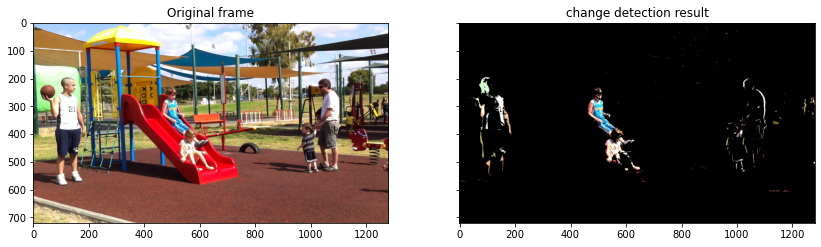

In [5]:
show_imgs(v_origin[62], v_foreground[62], "Original frame", "change detection result")

**A2. Post Processing for  change detection**

**Answer:** Suggest a post processing algorithm for improving  the results of a change detection algorithm (e.g., remove noise or fill gaps). 

**Code:** implement your algorithm.

*Input:*  v_original, v_foreground\
v_original: the original video\
v_foreground: the output of B1

*output:* v_PP_foreground\
v_PP_foreground: the result of the post processing on v_foreground.


**Note:**
1. You may want to generate from v_foreground  a binary mask of the foreground regions.
2. You can use dilation or erosion on a the binary mask.
3.  You may use additional frames to improve the results, but you do not have to.


# Answer: 

We'll remove noise and fill gaps:
    
    for frame from v_foreground:
    
        1. create binary mask which each pixel from the foreground is 1 and 0 otherwise.
        2. calculate connected component on the binary mask.
        3. remove components with low elements count.
        
    after we removed the noise, we can use dilation in order to represent as much pixels of the
    moving objects.
    
     for frame in v_foreground:

        1. create binary mask which each pixel from the updated foreground frame is 1 and 0
        otherwise.
        2. use convolution/dilation in order to dilate each 1's pixel on the binary mask.
        3. add the original pixel's intensity where there is 1 in the binary mask.
        

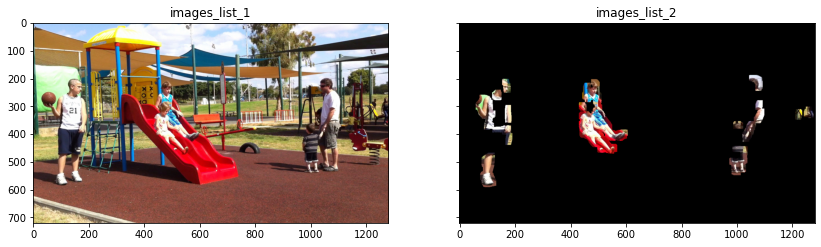

In [6]:
def remove_noise_and_fil_gaps(origin_img, img, threshold, ix):
    """
    Remove noise and fill gaps
    Parameters:
    
    origin_img(np.array): The original frame 
    img(np.array): The v_foreground frame 
    threshold(Integer): min component's pixels count  

    Returns:
        np.array: The image after cleaning
    """
    new_im = img[:, :, 0]
        
    labels, connected_mat = cv2.connectedComponents(new_im, connectivity=8)
              
    connected_groups_sums = defaultdict(int)
    for i in connected_mat.flatten():
        connected_groups_sums[i] += 1

    
    for i in range(len(connected_mat)):
        
        current_group = [0, connected_mat[i][0]]  # index, group_num
        for j in range(len(connected_mat[0])):
            if connected_mat[i][j] == 0:
                continue
            if connected_groups_sums[connected_mat[i][j]] < 40:
                
                img[i][j]= [0, 0, 0]
    
    new_im = img[:, :, 0]
    #h = cv2.dilate(new_im,np.ones((30,30)))
    h = convolve2d(new_im, np.ones((20,20)), mode = 'same')
    
    for i in range(len(h)):
        for j in range(len(h[0])):
            
            if h[i][j] != 0:
                img[i][j]= origin_img[i][j]
    
    return img


def improve_foreground(v_original, v_foreground):

    """
    perform a convolution and after that create a binary mask, after the binary mask take the original pixels
    """
    
    v_PP_foreground = list()
    foreground_objects_counts_lst = list()
    for ix, img in enumerate(v_foreground):
        
        final_image = remove_noise_and_fil_gaps(v_original[ix], img, threshold, ix)
        
        v_PP_foreground.append(final_image)
    return np.array(v_original), np.array(v_PP_foreground)



v_original, v_PP_foreground = improve_foreground(v_origin, v_foreground)

'''video_name = f'v_convolved_{8}'
create_video(v_PP_foreground, video_name)'''

show_imgs(v_original[50], v_PP_foreground[50], "images_list_1", "images_list_2")


**A3. Counting  foreground objects**

Write a function that counts the number of foreground objects in the result of A1 or A2. 

*Input:* v_foreground\
v_foreground: a video which is the output of B1 or B2

*Output*: c\
c: a vector with the number of foreground objects in each of the frames

**Note:** You can use a function that counts connected components in a binary image.


In [7]:
def count_foreground_objects(v_foreground):
    c = list()
    
    for ix, img in enumerate(v_foreground):
        low_values_flag = 1
        
        new_im = img[:, :, 0]
        result = cv2.threshold(new_im, 0, low_values_flag, cv2.THRESH_BINARY)[1]  # binary_mask
        parsed_array = np.array(result, dtype=np.uint8)
        
        labels_count, connected_mat = cv2.connectedComponents(parsed_array, connectivity=8)
        c.append(labels_count)
        print(f'frame: {ix +1} foreground objects count: {labels_count}')
    
    return c


print(count_foreground_objects(v_PP_foreground))

frame: 1 foreground objects count: 19
frame: 2 foreground objects count: 19
frame: 3 foreground objects count: 19
frame: 4 foreground objects count: 16
frame: 5 foreground objects count: 15
frame: 6 foreground objects count: 15
frame: 7 foreground objects count: 18
frame: 8 foreground objects count: 15
frame: 9 foreground objects count: 17
frame: 10 foreground objects count: 13
frame: 11 foreground objects count: 15
frame: 12 foreground objects count: 12
frame: 13 foreground objects count: 14
frame: 14 foreground objects count: 10
frame: 15 foreground objects count: 13
frame: 16 foreground objects count: 15
frame: 17 foreground objects count: 13
frame: 18 foreground objects count: 12
frame: 19 foreground objects count: 11
frame: 20 foreground objects count: 8
frame: 21 foreground objects count: 13
frame: 22 foreground objects count: 9
frame: 23 foreground objects count: 10
frame: 24 foreground objects count: 11
frame: 25 foreground objects count: 10
frame: 26 foreground objects count: 

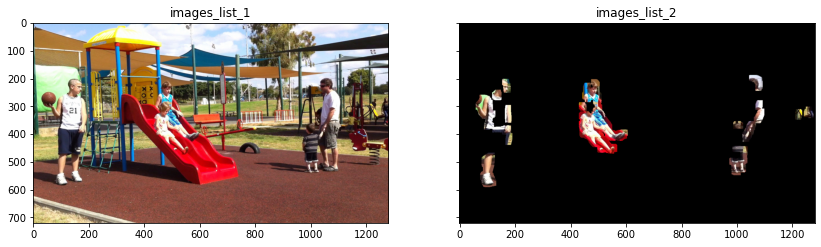

In [8]:
show_imgs(v_original[50], v_foreground[50], "images_list_1", "images_list_2")

## Section B: Compute Optical Flow (OF) using Lucas-Kanade

**B1. Basic Lucas Kanade OF**

Impelment the basic Lucas-Kanade we leared in class.

*Input:*  name_file, nf1, nf2,  sigma_R, sigma_S\
name_file: a name of a video file\
f1 and f2: the numbers of the two frames form the video on which the OF is computed.\
sigma_S: the variance of the Gaussian used for the  spatial smoothing  as in HW1 (for computing the derivative of a Gaussian).\
sigma_R: the variance of the Gaussian for computing the sum of the derivatives (the convolution replace the sum).

*Output:* U, V, im1,im2\
U, V:  two matrices with the x and y motion for each pixel, respectively.\
im1, im2: the frames on which the optical flow was computed (their number in the video is nf1 and nf2).

**Note:**
1. You can use any video reading method you find convenient.
2. Do not forget to convert the images into grey scale.
3. You can compute the derivatives of the images as in HW1 - convolution with the derivative of a Gaussian.
3. You can resize the images in order for the program to run faster.
5. The computed OF is not necessarily integers. You may want to perform float computation.
6. For sigma_R look at slide 63 of Class 7.

In [9]:
# Helper functions from HW1:

def gaussian(x, y, sigma):
    return np.exp(-0.5 * (np.square(x) + np.square(y)) / np.square(sigma))


def gaussian_derivative(axis, x, y, sigma):
    axis_parameter = x if axis == 'x' else y
    return (-axis_parameter/2*np.pi*sigma**4)*np.exp(-(np.square(x) + np.square(y))/(2*sigma**2))


def get_gaussian_kernel(sigma=1., mask_size=5, axis='x', kernel_mode=''):
    """
    Creates Gaussian kernel with side length mask_size and given sigma
    """
    mask_size = int(mask_size)
    
    if (mask_size % 2) == 0:
        mask_size += 1
        
    ax = np.linspace(-(mask_size - 1) / 2., (mask_size - 1) / 2., mask_size)
    xx, yy = np.meshgrid(ax, ax)

    if kernel_mode == 'der':
        kernel = gaussian_derivative(axis, xx, yy, sigma)
    else:
        kernel =  gaussian(xx, yy, sigma)

    return kernel / np.sum(kernel)

In [10]:
# Helper functions for section B:

def play_video(filename):
    cap = cv2.VideoCapture(filename)

    while(cap.isOpened()):
        ret, frame = cap.read()
        
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            cv2.imshow('frame',frame)
            cv2.waitKey(30)
        else:
            break
    cap.release()


def save_all_frames(filename):
    vidcap = cv2.VideoCapture(filename)
    success,image = vidcap.read()
    count = 0
    
    while success:
        greyscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converting the images into greyscale
        cv2.imwrite("frame%d.jpg" % count, greyscaled_image) # saving frame as JPEG file
        success,image = vidcap.read()
#         print(f'Read frame number {count}: {success}')
        count += 1


def get_all_frames_as_list(filename):
    frames_list = []
    vidcap = cv2.VideoCapture(filename)
    success,image = vidcap.read()
    count = 0
    
    while success:
        greyscaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # converting the images into greyscale
        frames_list.append(greyscaled_image)
        success,image = vidcap.read()
        count += 1
    
    return frames_list


def resize(img, scale_percent=30):
    scale_percent = scale_percent
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)


def get_C_naive(A_matrix):
    return np.matmul(A_matrix.T, A_matrix)


def get_C_modified(masked_x_matrix, masked_y_matrix, masked_xy_matrix, row, column):
    C = np.zeros((2,2))
    C[0,0] = masked_x_matrix[row, column]
    C[0,1] = masked_xy_matrix[row, column]
    C[1,0] = masked_xy_matrix[row, column]
    C[1,1] = masked_y_matrix[row, column]
    
    return C


def get_U_V(x_matrix, y_matrix, t_matrix, window_size, sigma_R):
    rows, columns = x_matrix.shape
    pad = window_size//2
    U = np.zeros((rows, columns))
    V = np.zeros((rows, columns))
    THRESHOLD = 0.05 # Threshold below which SVD values are considered zero.
    
    ### C modification part: lecture 7, slide 63
#     MODE = 'same'
#     mask_size_R = sigma_R * 4
#     G = get_gaussian_kernel(sigma_R, mask_size_R) # a standard Gaussian mask/kernel
#     masked_x_matrix = convolve2d(np.square(x_matrix), G, mode = MODE)
#     masked_y_matrix = convolve2d(np.square(y_matrix), G, mode = MODE)
#     masked_xy_matrix = convolve2d(x_matrix*y_matrix, G, mode = MODE)
    ###
    
    for i in range(pad, rows-pad): # starting at 'pad' and end 'pad' early becasue of the window padding - to not go out of bounds
        for j in range(pad, columns-pad):
            Ix = x_matrix[i-pad : i+pad+1, j-pad : j+pad+1].flatten()
            Iy = y_matrix[i-pad : i+pad+1, j-pad : j+pad+1].flatten()
            It = t_matrix[i-pad : i+pad+1, j-pad : j+pad+1].flatten()
            A = np.vstack((Ix, Iy)).T # making it a 2-column vector
            b = np.reshape(It, (It.shape[0], 1)) # changing It representation and make It a single-column array/vector
            C = get_C_naive(A) # C = AT*A
#             C = get_C_modified(masked_x_matrix, masked_y_matrix, masked_xy_matrix, i, j)
            
            if np.linalg.matrix_rank(C, THRESHOLD) >= 2:
                result = np.matmul(np.linalg.pinv(A), b)
                U[i,j] = result[0]
                V[i,j] = result[1]
    
    return U, V

In [11]:
def basic_LK_OF(name_file, nf1, nf2, sigma_S, sigma_R, get_U_V=get_U_V):
    frames_list = get_all_frames_as_list(name_file)
    
    im1 = frames_list[nf1]
    im2 = frames_list[nf2]
    
    rows, columns = im1.shape
    resoultion = rows*columns
    
    TH1 = 800 * 1000
    
#     the window_size needs to scale according to the resoultion
    if resoultion > TH1:
        window_size = 43
    else:
        window_size = 20
        
    return basic_LK_OF_helper(im1, im2, sigma_S, sigma_R, window_size)


def basic_LK_OF_helper(im1, im2, sigma_S, sigma_R, window_size, get_U_V=get_U_V):
    '''
    This function gets the images as is (after fetching them in "basic_LK_OF")
    and a window size based on the images' resolution
    '''
    mask_size_S = sigma_S * 4
    MODE = 'same'
    BOUNDARY = 'symm'
    GAUSSIAN_KERNEL_MODE = 'der'
    
    mask_x = get_gaussian_kernel(sigma_S, mask_size_S, 'x', GAUSSIAN_KERNEL_MODE)
    mask_y = get_gaussian_kernel(sigma_S, mask_size_S, 'y', GAUSSIAN_KERNEL_MODE)
    mask_t = np.ones((2,2))
    
    fx = convolve2d(im1,  mask_x, boundary = BOUNDARY, mode = MODE)
    fy = convolve2d(im1,  mask_y, boundary = BOUNDARY, mode = MODE)
    ft = convolve2d(im2,  mask_t, boundary = BOUNDARY, mode = MODE) -\
         convolve2d(im1, mask_t, boundary = BOUNDARY, mode = MODE)
    
    U, V = get_U_V(fx, fy, ft, window_size, sigma_R)
    
    return [U, V, im1, im2]

In [12]:
FOLDER = 'data'
# VIDEO = 'OneLeaveShopReenter2cor.mpg' # 559 frames, 300 X 400
VIDEO =  'SLIDE.avi' # 560 frames, 750 X 1200
name_file = f'{FOLDER}/{VIDEO}'

nf1 = 60
nf2 = 62
sigma_S = 1.
sigma_R = 2.

B1_results = basic_LK_OF(name_file, nf1, nf2, sigma_S, sigma_R)

**B2. Present OF results**

*Input:* im1, U, V (the output of Basic_LK_OF without im2).

*Output:* a quiver plot overlaid the input  frame

**Note:**
1. You can look at https://pythonforundergradengineers.com/quiver-plot-with-matplotlib-and-jupyter-notebooks.html
2. You may want for visualaization to uniformally resize the values of U and V - if they are too large or too small/
2. You may not want to draw the OF  each pixel - to avoid OF overlapping of neighboring pixels.

In [13]:
def OF_plot_results(U, V, im1):
    STEPS = 10
    rows, columns = im1.shape
    
    x_direction = U[::STEPS, ::STEPS] # filter out some pixels to avoid OF overlapping of neighboring pixels
    y_direction = V[::STEPS, ::STEPS]

    x = np.arange(0, columns, 1.0)
    y = np.arange(0, rows, 1.0)
    
    x_pos, y_pos = np.meshgrid(x, y)
    filtered_columns = x_pos[::STEPS, ::STEPS]
    filtered_rows = y_pos[::STEPS, ::STEPS]
    
    # Plot the optical flow
    plt.figure(figsize=(15, 15))
    plt.imshow(im1, cmap='gray')
    # we reduce visuality of small arrows to make it easier to see the more "important" areas
    #plt.quiver(filtered_columns, filtered_rows, x_direction, y_direction, color='y', minshaft=15, minlength = 0)
    plt.quiver(filtered_columns, filtered_rows, x_direction, y_direction, color='y', minshaft=10, minlength = 0)
    plt.title('A quiver plot overlaid the input frame', fontsize=20)
    plt.show()

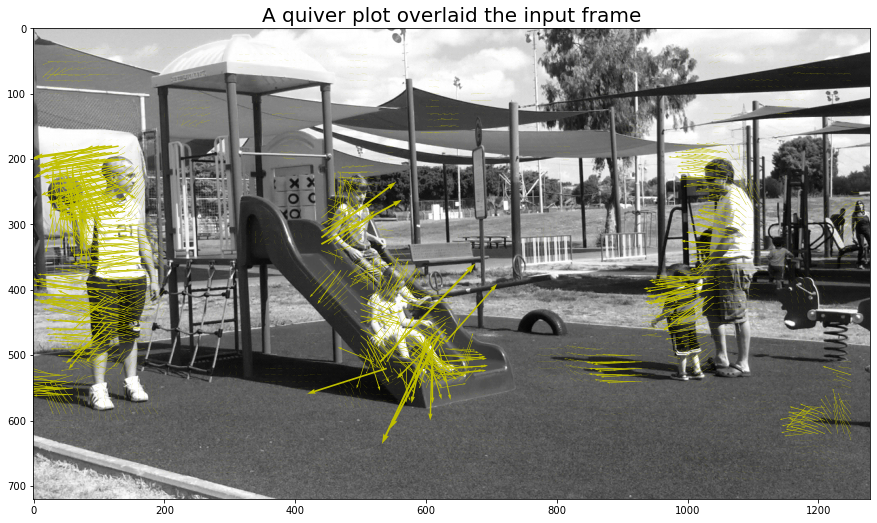

In [14]:
U, V, im1, im2 = B1_results
OF_plot_results(U, V, im1)
# The inconsistency probably follows noise from the moving camera

**B3. Evaluate OF results**

*Input:* im1, im2,  U, V (the output of Basic_LK_OF).

*Output:* w_im1, w_diff, err\
w_im1: the results of wrapping im1 using (U,V) toward im2 (matrix).\
w_diff:  |wraped_im1 -  im2| (matrix).\
err: the sum of square differences between w_im1 and im2 (scalar).

**Note:**\
 You can use any wrapping function you like from openCV or other code.


error: 12794504


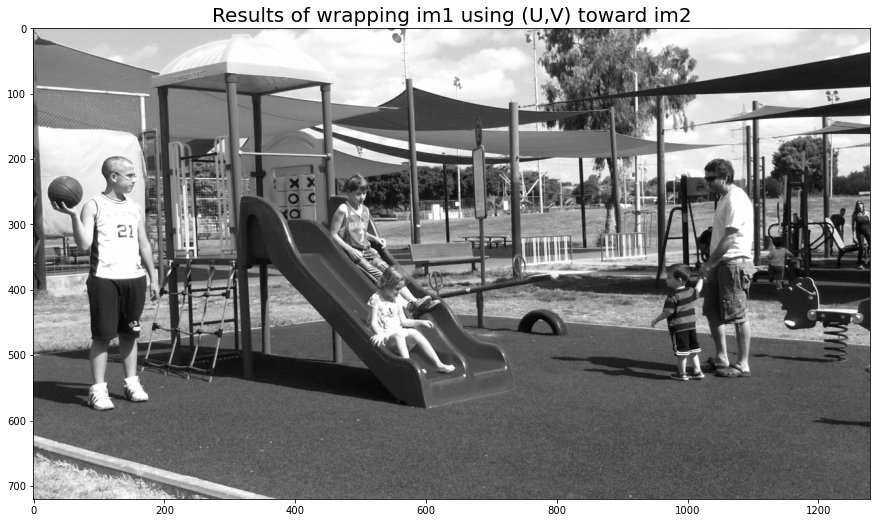

In [15]:
def eval_OF(im1, im2, U, V):
    rows, columns = im1.shape
    x = np.arange(0, columns, 1.0)
    y = np.arange(0, rows, 1.0)
    
    x_pos, y_pos = np.meshgrid(x, y)
    
    map_x_32 = (x_pos + U).astype('float32')
    map_y_32 = (y_pos + V).astype('float32')
    
    w_im1 = cv2.remap(im1, map_x_32, map_y_32, cv2.INTER_LINEAR)
    w_diff = np.absolute(w_im1 - im2)
    err = np.square(w_diff).sum()
    return [w_im1, w_diff, err]


w_im1, w_diff, err = eval_OF(im1, im2, U, V)
plt.figure(figsize=(15, 15))
plt.imshow(w_im1, cmap='gray')
plt.title('Results of wrapping im1 using (U,V) toward im2', fontsize=20)

print(f'error: {err}')

**B4. Affine_LK_OF**

Use the variant of Lucas-Kanade with affine motion instead of translation.
See slides - class 7 slides 73-75.

The input and output is the same as in **B1**.



In [16]:
def get_affine_U_V(x_matrix, y_matrix, t_matrix, window_size, sigma_R):
    rows, columns = x_matrix.shape
    pad = window_size//2
    U = np.zeros((rows, columns))
    V = np.zeros((rows, columns))
    
    mode = 'same'
    mask_size_R = sigma_R * 4
    G = get_gaussian_kernel(sigma_R, mask_size_R, '', 'normal') # a standard Gaussian mask/kernel
    masked_x_matrix = convolve2d(np.square(x_matrix), G, mode = mode)
    masked_y_matrix = convolve2d(np.square(y_matrix), G, mode = mode)
    masked_xy_matrix = convolve2d(x_matrix*y_matrix, G, mode = mode)
    
    x, y = np.meshgrid(range(rows), range(columns))

    for i in range(pad, rows-pad): # we start at 'pad' and end 'pad' early becasue of the window padding - to not go out of bounds
        for j in range(pad, columns-pad):
            
            X = xx[i - pad:i + pad + 1, j - pad:j + pad + 1].flatten()
            Y = yy[i - pad:i + pad + 1, j - pad:j + pad + 1].flatten()
            
            Ix = masked_x_matrix[i-pad : i+pad+1, j-pad : j+pad+1].flatten()
            x1_Ix = masked_x_matrix[i-pad : i+pad+1, j-pad : j+pad+1].flatten() * X 
            y1_IX = masked_x_matrix[i-pad : i+pad+1, j-pad : j+pad+1].flatten() * Y

            Iy = masked_y_matrix[i-pad : i+pad+1, j-pad : j+pad+1].flatten()
            x1_Iy = masked_y_matrix[i-pad : i+pad+1, j-pad : j+pad+1].flatten() * X 
            y1_Iy = masked_y_matrix[i-pad : i+pad+1, j-pad : j+pad+1].flatten() * Y
            
            It = t_matrix[i-pad : i+pad+1, j-pad : j+pad+1].flatten()
             
            B = np.vstack((Ix, x1_Ix, y1_IX, Iy, x1_Iy, y1_Iy)).T # make it a 6-column vector
            
            b = np.reshape(It, (It.shape[0], 1)) # change It representation and make It a single-column array/vector

            C = np.matmul(B.T, B)
                        
            if np.linalg.matrix_rank(C, 0.5) == 6:
                a = np.matmul(np.linalg.pinv(B), b)
                U[i,j] = a[0] + j * a[1] + a[2] * i
                V[i,j] = a[3] + j * a[4] + a[5] * i
            
                
    return U, V


def affine_LK_OF(video, nf1, nf2, sigma_S, sigma_R):   
    return basic_LK_OF(name_file, nf1, nf2, sigma_S, sigma_R, get_affine_U_V)


FOLDER = 'data'
# VIDEO = 'SLIDE.avi' # 559 frames, 300 X 400
VIDEO =  'cube.avi' # 560 frames, 750 X 1200
name_file = f'{FOLDER}/{VIDEO}'

nf1 = 3
nf2 = 4
sigma_S = 1.
sigma_R = 2.

B4_results = affine_LK_OF(name_file, nf1, nf2, sigma_S, sigma_R)

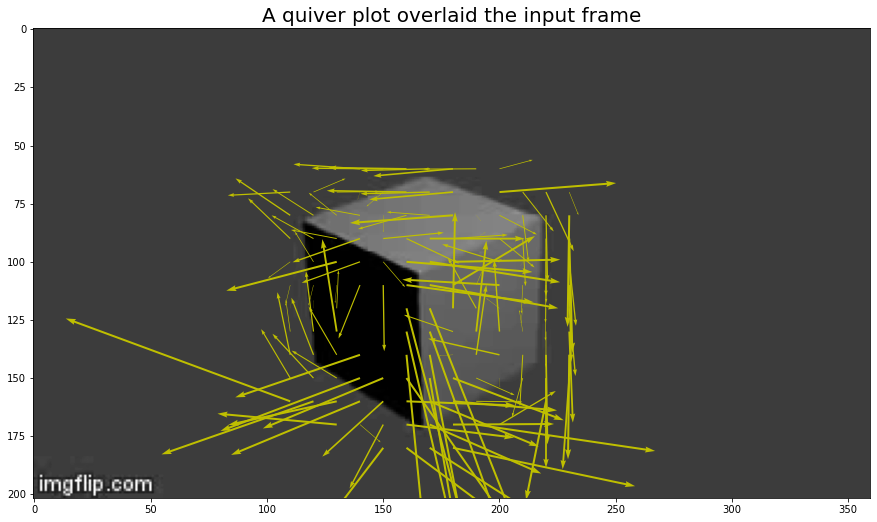

In [17]:
U, V, im1, im2 = B4_results
OF_plot_results(U, V, im1)
# The inconsistency probably follows noise from the moving camera

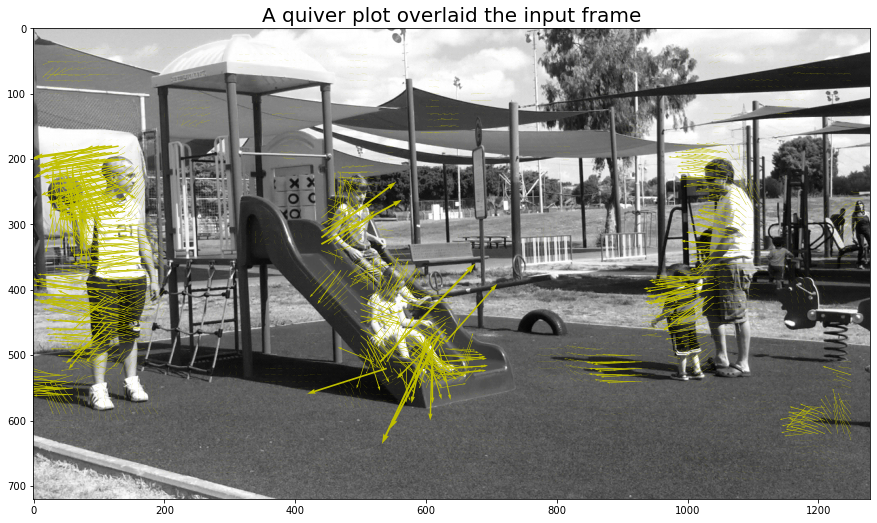

In [18]:
U, V, im1, im2 = B1_results
OF_plot_results(U, V, im1)
# The inconsistency probably follows noise from the moving camera

**B5. Apply and Discuss:**

Run the basic_LK_OF, and the affine_LK_OF on one or two videos, one with a static camera and the other with a moving camera.
Play with the frames chosen from each video, the algorithm parameters, and  the distance between nf1 and nf2.

**Answer:**
1. The disparity you compute in HW2 were integers while the OF is not necessarily integer. Expalin why. 
2. Explain theoretically for which regions the basic_LK_OF is expected to give good results and for which it does not.
2. Demonstrate your answer to (2) by displaying the results of OF overlaid im1  (Quiver overlayed im1), and mark good and bad results.
3. Explain theoretically when the basic_LK_OF is expected to fail while affine_LK_OF works well.
4. Find an example for (4)  (at least a region in the scene) and display it.
5. When two OF vectors have the same magnitude, are they necessarily corresponds to 3D points that moves at the same speed?


**SEE ATTACHED PDF!!!**

## Section C: Segementation  -- Not for submission

Part C will not be graded, hence,  **you do not have to submit it**. In case you would like to get feedback on it anyway - you are welcome to submit it.

**C1. Simple OF segemntation**

Use a simple segmentation (e.g., threshold) for the OF results based on the OF magnitude.

*Input:* U, V, any other parameters you find necessary
U, V - the OF vectors (e.g., computed by  B1 or B4).

*Output:* segments
im_segments is an image in which each segment is colored by a different color.


In [19]:
def im_segments = simple_segment_OF(U,V, "any other paramers")
   
    # Your code

SyntaxError: invalid syntax (<ipython-input-19-13a47f3c8b12>, line 1)

**C2. K-means OF segemntation**

Use k-mean segmentation for the OF results based on the OF magnitude and directions.

*Input:* U, V, any other parameters you find necessary\
U, V - the OF vectors (e.g., computed by  B1 or B4).

*Output:* im_segments\
im_segments is an image in which each segment is colored by a different color.

In [ ]:
def im_segments = simple_segment_OF(U,V, "any other paramers")
   
    # Your code

**C3. Apply  and answer**

1. Apply the functions in C1 and C2 on a video of your choice with a moving camera.
2. Discuss which method (C1 or C2) works better. Give an example.


**C4. OF used for change detection**

Assume that the video is taken by a static camera and use the results of C1 or C2 on the output in order to detect moving regions in the scene.

*input:* name_file, nf1, "any parameters you need"\
name_file: a name of a video file.\
nf1: the frame on which the OF is computed (nf1 and nf1+1).

*output*: v_change\
v_foreground: as in A1



In [ ]:
def [v_foreground] = OF_change_detection(name_file, nf1, "any parameters you need"):
    
    # your code

**C5. Change detection comparisons**

Choose a video taken from a static camera (one of the videos you used for change detection). 

1. Apply the functions A1 or A2 and C4.
4. Discuss which method (A1 or C4) works better. Give an example.
5. Count the number of moving regions for A1, A3, and C4. 